In [1]:
import itertools
import pandas as pd
import numpy as np
import binascii
import pygraphviz as pgv
import graphviz

In [2]:
################################################################
#create the checksum from an dataframe with unsorted motion IDs#
################################################################

def CRC32(IDs):
    crc = binascii.crc32(str(np.asarray(IDs)))
    return np.uint32(crc)
                         
#########################################################
#calculate duration and checksum with unsorted motion ID#
#########################################################

def aggregate(x):
    names = {
        'caseID': x['caseID'].max(),
        'checksum': CRC32(x['motionID'])
        }

    return pd.Series(names, index=['caseID', 'checksum'])

In [3]:
#read event log from CSV
eventLog = pd.read_csv('C:/Users/Wolfgang/Documents/PhD/syntheticLog/syntheticLogHighVariants.csv', index_col = False)
#change start and end time column values to tyoe timestamp
eventLog['startTime'] = pd.to_datetime(eventLog['startTime'], format = '%d/%m/%Y %H:%M:%S')
eventLog['completeTime'] = pd.to_datetime(eventLog['completeTime'], format = '%d/%m/%Y  %H:%M:%S')

In [4]:
#copy and filter by style 1
#style1Log = eventLog.loc[(eventLog['style'] == 1)].copy()
style1Log = eventLog.copy()
#delete not needed columns
del style1Log['style']

In [5]:
#create a blank result matrix based on the event logs motion ID
DSM = style1Log.groupby('motionID').size().reset_index(name='counts')[['motionID']].copy()

#create columns matching the rows and fill with false
for index, row in DSM.iterrows():
    DSM[row['motionID']] = False

#make motionID the index
DSM.set_index('motionID', inplace=True)
oDSM = DSM.copy()

In [6]:
#split log into start and complete events
#create a copy
style1aLog = style1Log.copy()
#delete complete column
del style1aLog['completeTime']
#rename start column
style1aLog.rename(columns = {'startTime':'timestamp'}, inplace = True)
#add type column = start
style1aLog['type'] = 'start'

#create a copy
style1bLog = style1Log.copy()
#delete start column
del style1bLog['startTime']
#rename complete column
style1bLog.rename(columns = {'completeTime':'timestamp'}, inplace = True)
#add type column = start
style1bLog['type'] = 'complete'

#concat the two pandas
styleLog = pd.concat([style1aLog,style1bLog])
#sort by timestamp, type and motion ID
styleLog = styleLog.sort_values(['timestamp','type','motionID'] ,ascending = [True, True, True])
#index newly
styleLog.reset_index(inplace=True, drop=True)

In [7]:
#create a summary over the log with start and complete events which includes the checksum over the motionID
logSummary = styleLog.groupby(['caseID']).apply(aggregate)

#find for each trace class (defined through the checksum) the ID of a matching case
traces = logSummary.groupby(['checksum']).min()['caseID'].reset_index(name='caseID')

#get the case for each trace class found
traceLog = styleLog.loc[styleLog['caseID'].isin(traces['caseID'])]
traceLog.reset_index(inplace=True, drop=True)

In [8]:
#iterate through the condensed log
for index, row in traceLog.iterrows():
    #if a complete event is found store the current motion ID as column number and the current case number
    if traceLog.loc[index]['type'] == 'complete':
        columnValue = traceLog.loc[index]['motionID']
        currentCase = traceLog.loc[index]['caseID']
        iterationPointer = index
        startFound = 0
        #iterrate through the remainder of that case and make a mark in the DSM for every start found prior to another complete
        while ((traceLog.loc[iterationPointer]['type'] == 'start') or (startFound == 0)) and traceLog.loc[iterationPointer]['caseID'] == currentCase:
            if traceLog.loc[iterationPointer]['type'] == 'start':
                startFound = 1
                rowValue = traceLog.loc[iterationPointer]['motionID']
                DSM.loc[rowValue, columnValue] = True
            iterationPointer += 1
            if iterationPointer == len(traceLog):
                break

DSM.astype(int)

,1,2,3,4,5,6,7,8,9,10,11,12,13
motionID,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,0,1,0,1,0,0,0,0,0
6,1,1,1,1,1,0,1,0,0,0,0,0,0
7,0,1,1,1,1,1,0,1,1,1,0,0,0
8,0,1,1,1,1,1,1,0,0,0,0,0,0
9,0,0,0,0,1,0,1,1,0,0,0,0,0


In [9]:
DSM.astype(int).to_csv('C:\\Users\\Wolfgang\\Documents\\PhD\\syntheticLog\\matrix1.csv')

In [10]:
#iterate through the condensed log
for index, row in traceLog.iterrows():
    #if a start event is found store the current motion ID as column number and the current case number
    if traceLog.loc[index]['type'] == 'start':
        columnValue = traceLog.loc[index]['motionID']
        currentCase = traceLog.loc[index]['caseID']
        iterationPointer = index
        #iterrate through the remainder of that case and make a mark in the oDSM for every complete found
        while traceLog.loc[iterationPointer]['caseID'] == currentCase:
            if traceLog.loc[iterationPointer]['type'] == 'complete':
                rowValue = traceLog.loc[iterationPointer]['motionID']
                oDSM.loc[rowValue, columnValue] = True
            iterationPointer += 1
            if iterationPointer == len(traceLog):
                break

oDSM.astype(int)

,1,2,3,4,5,6,7,8,9,10,11,12,13
motionID,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0,0,0,0
3,1,1,1,1,1,1,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,0,0,0,0,0,0
5,1,1,1,1,1,1,0,1,1,1,0,0,0
6,1,1,1,1,1,1,1,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1,1,1,0,0,0
8,1,1,1,1,1,1,1,1,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,0,0,0,0


In [11]:
oDSM.astype(int).to_csv('C:\\Users\\Wolfgang\\Documents\\PhD\\syntheticLog\\matrix2.csv')

In [12]:
#transpose matrix
oDSM = oDSM.T
#invert matrix
oDSM = ~oDSM
oDSM.astype(int)

motionID,1,2,3,4,5,6,7,8,9,10,11,12,13
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,0,1,0,0,0,0,0,0,0,0
8,1,1,1,1,0,1,0,0,0,0,0,0,0
9,1,1,1,1,0,1,0,1,0,0,0,0,0
10,1,1,1,1,0,1,0,1,1,0,0,0,0


In [13]:
#DSM AND oDSM
resultMatrix = (DSM & oDSM).astype(int)
resultMatrix

,1,2,3,4,5,6,7,8,9,10,11,12,13
motionID,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,1,0,1,0,0,0,0,0,0,0,0
8,0,1,1,1,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,0,0,0


In [14]:
resultMatrix.to_csv('C:\\Users\\Wolfgang\\Documents\\PhD\\syntheticLog\\matrix3.csv')

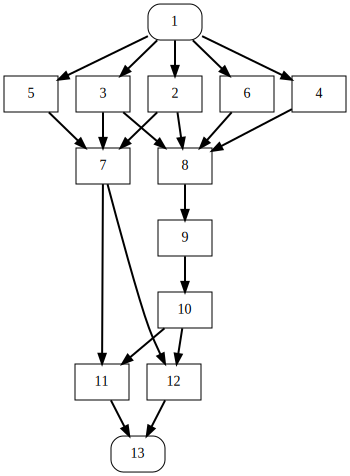

In [15]:
#draw graph of result matrix
#define graph
G = pgv.AGraph(strict=True, directed=True)
G.graph_attr['rankdir'] = 'TB'

#iterate through matrix and create nodes
rowCount = 1
for index, row in resultMatrix.iterrows():
    if rowCount == 1 or rowCount == len(resultMatrix):
        G.add_node(index, label=index, shape='box', style='filled, rounded', fillcolor='white', fontcolor='black', xlp="")
    else:
        G.add_node(index, label=index, shape='box', style='filled', fillcolor='white', fontcolor='black', xlp="")
    rowCount += 1

#iterate through matrix and create edges
for index, row in resultMatrix.iterrows():
    for column in resultMatrix.columns:
        if row[column]:
            G.add_edge(column, index, label='', penwidth=2)

            
graphviz.Source(G)

In [16]:
G.draw('C:\\Users\\Wolfgang\\Documents\\PhD\\syntheticLog\\lowVariantsStyle1Model.eps', prog='dot')